#
<center> -------------------------------------------------------------------- </center>

# <center> Simulation Protocol </center>

<center> -------------------------------------------------------------------- </center>

# imports

In [ ]:
import argparse, math, sys, os, time, glob
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt

# OpenMM related
import simtk.openmm as mm
from simtk.openmm.app.modeller import Modeller
import simtk.openmm.app.forcefield as FF  # ForceField, PME, HBonds, AllBonds
from simtk.openmm.app.simulation import Simulation
import simtk.unit as unit
from simtk.openmm.app import PDBFile, PDBxFile
from pdbfixer.pdbfixer import PDBFixer

# needed to output in xtc and for discarding water in output
from mdtraj.reporters import DCDReporter, XTCReporter

# find longest dist in protein (named diagonal in GMX)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress # assess slopes


# visualization
try:
    import nglview as nglv
    import mdtraj as md

    visualise = True
except:
    print("nglview not installed - cannot visualise trajectory")
    visualise = False

# Helper functions: 

In [16]:
# ========================================================
# helpers for building system
# ========================================================


def get_longest_distance(modeller):
    """
    Finds the longest distance between any two atoms in the protein.
    In Gromacs this is refered to as the Diagonal in gmx editconf.
    Changed from openMM's longest dist in any single dimension.
    """
    positions = modeller.getPositions()
    coordinates = np.array(positions.value_in_unit(unit.nanometers))
    pairwise_dist = pdist(coordinates, metric="euclidean")
    pairwise_dist = squareform(pairwise_dist)
    max_dist = pairwise_dist.max()
    max_dist = max_dist * unit.nanometers
    print("\nLargest pairwise distance (diagonal) in protein :")
    print(f"\t{max_dist} ")

    return max_dist


def get_box_vectors(max_dist, box_padding, box_geometry="dodecahedron"):
    """
    Create box vectors for either rhombic dodecahedron, truncated octahedron
    or cubic box.
    See paper below for math behind how trigonal boxes can be simulated as cubic:
    https://doi.org/10.1002/(SICI)1096-987X(19971130)18:15%3C1930::AID-JCC8%3E3.0.CO;2-P
    Obs!: truncated Octahedron refered to as octahedron,
    rhombic dodecahedron refered to as dodecahedron.
    """

    box_geometry = box_geometry.lower()

    # check  geometry is implemented
    assert box_geometry in [
        "dodecahedron",
        "octahedron",
        "cubic",
    ], f"Box geometry {box_geometry} not implemented"

    # double padding as must pad on each side of protein
    padding = 2 * box_padding

    # create box vectors dependent on geometry
    if box_geometry == "dodecahedron":
        dhedron_vectors = (
            mm.Vec3(1, 0, 0),
            mm.Vec3(0, 1, 0),
            mm.Vec3(0.5, 0.5, math.sqrt(2) / 2),
        )

        box_vectors = [(max_dist + padding) * v for v in dhedron_vectors]

    elif box_geometry == "octahedron":
        oct_vectors = (
            mm.Vec3(1, 0, 0),
            mm.Vec3(1 / 3, 2 * sqrt(2) / 3, 0),
            mm.Vec3(-1 / 3, 1 / 3, sqrt(6) / 3),
        )
        box_vectors = [(max_dist + padding) * v for v in oct_vectors]

    elif box_geometry == "cubic":
        cubic_vectors = mm.Vec3(1, 0, 0), mm.Vec3(0, 1, 0), mm.Vec3(0, 0, 1)
        box_vectors = [(max_dist + padding) * v for v in cubic_vectors]

    print(
        f"\nBuiling {box_geometry} box with vectors:\n",
        f"\t {box_vectors[0]}\n",
        f"\t {box_vectors[1]}\n",
        f"\t {box_vectors[2]}",
    )

    return box_vectors


# ========================================================
# helpers for positional restraints in equilibration
# ========================================================


def add_pos_restraints(system, fc_bb, fc_sc):
    """
    Adds positional restraints on heavy backbone and sidechain atoms
    """

    ### add restraints on backbone ###
    force_bb = mm.CustomExternalForce(
        "k_bb*periodicdistance(x, y, z, x0, y0, z0)^2"
    )  # harmonic
    force_bb.addGlobalParameter("k_bb", fc_bb)  # add spring constant
    force_bb.addPerParticleParameter("x0")
    force_bb.addPerParticleParameter("y0")
    force_bb.addPerParticleParameter("z0")

    force_sc = mm.CustomExternalForce(
        "k_sc*periodicdistance(x, y, z, x0, y0, z0)^2"
    )  # harmonic
    force_sc.addGlobalParameter("k_sc", fc_sc)  # add spring constant
    force_sc.addPerParticleParameter("x0")
    force_sc.addPerParticleParameter("y0")
    force_sc.addPerParticleParameter("z0")

    # specify heavy atoms in backbone and sidechain
    bb_heavy = ["CA", "C", "N", "O"]
    sc_heavy = [
        "CB",
        "CD",
        "CD1",
        "CD2",
        "CE",
        "CE1",
        "CE2",
        "CE3",
        "CG",
        "CG1",
        "CG2",
        "CZ",
        "CZ2",
        "CZ3",
        "ND2",
        "NE1",
        "NE2",
        "NZ",
        "OD1",
        "OD2",
        "OE1",
        "OE2",
        "OG1",
        "OXT",
        "SD",
    ]

    # get each atoms coords
    coords = [coord for idx, coord in enumerate(modeller.positions)]
    atoms = [atom for atom in modeller.topology.atoms()]

    # add restraint force to heavy atoms
    for idx, atom in enumerate(atoms):
        if atom.name in bb_heavy:
            force_bb.addParticle(idx, coords[idx])
        elif atom.name in sc_heavy:
            force_sc.addParticle(idx, coords[idx])

    # enabling tracking of force groups
    for force in system.getForces():
        force.setForceGroup(9)  # all non-restrained forces
    force_bb.setForceGroup(10)
    force_sc.setForceGroup(11)

    # add force
    system.addForce(force_bb)
    system.addForce(force_sc)

    return system


def remove_pos_restraints(simulation):
    """
    Removes the positional restraints on the heavy atoms by reinitializing
    the context.
    """
    # get all forces in the system
    forces = [(idx, force) for idx, force in enumerate(simulation.system.getForces())]

    # remove the custom added forces
    for (idx, force) in reversed(forces):  # reversed to avoid indx deletion
        if force.__class__.__name__ == "CustomExternalForce":
            simulation.system.removeForce(idx)

    # ensure forces removed in context as well as system. Important!
    simulation.context.reinitialize(preserveState=True)

    return simulation


def test_removed_restraints(simulation):
    """
    test correct implementation of force removal
    """
    # test energy of  restraining forces in context
    E_bb_force = simulation.context.getState(
        getEnergy=True, groups={10}
    ).getPotentialEnergy()  # group 10 = bb

    E_sc_force = simulation.context.getState(
        getEnergy=True, groups={11}
    ).getPotentialEnergy()  # group 11 = sc

    # convert to float item
    E_bb_force = E_bb_force.value_in_unit(unit.kilojoule_per_mole)
    E_sc_force = E_sc_force.value_in_unit(unit.kilojoule_per_mole)

    if E_bb_force > 0:
        return False
    elif E_sc_force > 0:
        return False
    else:
        return True


def test_force_groups(simulation):
    """
    checks number of forces/restraints and their energies
    """

    # calculate energy of each added force group
    print(
        "\n\nTotal energy:\n\t",
        simulation.context.getState(getEnergy=True).getPotentialEnergy(),
        "\nEnergy  - original forces, fg=9: \n\t",
        simulation.context.getState(getEnergy=True, groups={9}).getPotentialEnergy(),
        "\nEnergy - backbone restraints, fg=10: \n\t",
        simulation.context.getState(getEnergy=True, groups={10}).getPotentialEnergy(),
        "\nEnergy. - sidechain restraints, fg 11: \n\t",
        simulation.context.getState(getEnergy=True, groups={11}).getPotentialEnergy(),
    )
    # get how many force groups are in simulation
    print(f"# of forces:\n\t{simulation.system.getNumForces()}\n")


# ========================================================
# helpers for assessing equilibration
# ========================================================


def get_energy(current_state):
    """
    returns current energy of system
    """
    # track energy at current time step
    current_energy = current_state.getPotentialEnergy()
    current_energy = current_energy.value_in_unit(unit.kilojoule_per_mole)

    return current_energy


def get_rmsd(current_state, modeller):
    """
    returns rmsd of current state/simulation compared to input pdb structure
    """
    sim_coords_all = current_state.getPositions()
    sim_coords = get_CA_coords(modeller, sim_coords_all)
    pdb_coords = get_CA_coords(modeller)
    sim_rmsd = calculate_rmsd(pdb_coords, sim_coords)

    return sim_rmsd


def get_CA_coords(modeller, coords_all=None):
    """
    Retrieves the coordinates belonging to C-alpha atoms only
    """
    if coords_all == None:
        coords_all = modeller.positions

    coords = [coord for idx, coord in enumerate(coords_all)]
    atoms = [atom for atom in modeller.topology.atoms()]
    coords_CA = []
    for idx, atom in enumerate(atoms):
        if atom.name == "CA":
            coord = coords[idx].value_in_unit(unit.angstrom)
            x = coord[0]
            y = coord[1]
            z = coord[2]
            coords_CA.append([x, y, z])

    return coords_CA


def calculate_rmsd(pdb_coords, sim_coords):
    """
    Aligns and calculates RMSD between input structure and simulated
    Structure.
    Based on Marloes Arts code
    """
    pdb_coords, sim_coords = np.array(pdb_coords), np.array(sim_coords)

    assert (
        pdb_coords.shape == sim_coords.shape
    ), "Error, number of input and simulation coordinates are not the same"

    # Numpy implementation
    P = pdb_coords.squeeze()
    Q = sim_coords.squeeze()
    P -= np.mean(P, axis=0, keepdims=True)
    Q -= np.mean(Q, axis=0, keepdims=True)
    C = np.dot(np.transpose(P), Q)
    V, S, W = np.linalg.svd(C)
    d = np.linalg.det(V) * np.linalg.det(W)
    if d < 0.0:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    # Rotate P
    P = np.dot(P, U)

    rmsd = np.sqrt(np.mean(np.sum((P - Q) ** 2, axis=1)))

    return rmsd


def is_equilibrated(trajectory, window, stride, thrshold=1.0):
    """
    Checks if trajectory is equilibrated based on rolling windows.
    Deemed equilibrated if the average of each window  does not deviated
    more than 1 (average) std from all other window's averages

    """
    # create rolling windows from trajectory with stride
    rolling_windows = rolling_window(trajectory, window, stride)

    # get avg, std per window
    avg = np.mean(rolling_windows, axis=1)
    std = np.std(rolling_windows, axis=1)

    # check if all pairwise dist of averages are less than:
    # <thrshold> x standard deviations   => equilibrated
    pairwise_dist_avg = np.abs(avg[:, None] - avg[None, :])
    rel_dist = pairwise_dist_avg / np.mean(std)

    equilibrated = np.all(np.less(rel_dist, thrshold))

    return equilibrated


def rmsd_is_equilibrated(trajectory, window, stride, thrshold=1.0):
    rolling_windows = rolling_window(trajectory, window, stride)

    # get slopes
    rolling_slopes = linear_regression(rolling_windows)


def rolling_window(measurement, window=100, stride=10):
    """ returns rolling windows for a given measurement/trajectory """

    rolling_windows = [
        measurement[i : i + window] for i in range(0, len(measurement) - window, stride)
    ]

    return np.array(rolling_windows)


def plot_equilibration(measurement, timestep, name=None):
    try:
        timestep = timestep.value_in_unit(unit.picoseconds)
    except:
        pass
    timesteps = np.arange(len(measurement)) * timestep
    plt.scatter(timesteps, measurement, s=5)
    plt.xlabel("Trajectory [ps]")
    if name == None:
        plt.ylabel("measurement")
    elif type(name) == str:
        plt.ylabel(name)
    plt.show()


# ========================================================
# helpers for saving production run
# ========================================================


def discard_solvent(modeller):
    """
    returns indices of all solute (non-solvent).
    Used to discard solvent in traj output
    """
    solute_indices = []
    atoms = [atom for atom in modeller.topology.atoms()]
    solvent_residues = [
        "HOH",
        "HO4",
        "HO5",
        "TIP3",
        "TIP4P",
        "SOL",
        "NA",
        "CL",
        "CLA",
        "SOD",
    ]

    for idx, atom in enumerate(atoms):
        if not atom.residue.name in solvent_residues:
            solute_indices.append(idx)

    return solute_indices


def setup_reporter_files(simulation, out_steps, name_pdb, out_format, modeller):
    """
    Sets reporters for saving and logging the simulation.
    Does not save water in trajectory, to save space.
    """
    out_steps = int(out_steps)  # avoids weird crash

    # to discard water in saved coordinates:
    solute_indices = discard_solvent(modeller)

    # define output format
    if out_format.lower() == "dcd":
        out_name = f"{name_pdb}_trajectory.dcd"
        reporter = DCDReporter(out_name, out_steps, atomSubset=solute_indices)

    elif out_format.lower() == "xtc":
        out_name = f"{name_pdb}_trajectory.xtc"
        reporter = XTCReporter(out_name, out_steps, atomSubset=solute_indices)

    # save in the specified traj format
    simulation.reporters.append(reporter)

    # set stdout for simulation
    simulation.reporters.append(
        mm.app.StateDataReporter(
            sys.stdout,
            out_steps,
            step=True,
            potentialEnergy=True,
            temperature=True,
            progress=True,
            remainingTime=True,
            speed=True,
            totalSteps=sim_steps,
            separator="\t",
        )
    )
    # set log file for simulation
    simulation.reporters.append(
        mm.app.StateDataReporter(
            f"log_{name_pdb}.log",
            out_steps,
            time=True,
            totalEnergy=True,
            temperature=True,
            progress=True,
            remainingTime=True,
            speed=True,
            totalSteps=sim_steps,
            separator="\t",
        )
    )

    return reporter


def save_checkpoint(simulation, system, integrator, name_pdb):
    state = simulation.context.getState(
        getPositions=True,
        getVelocities=True,
        getForces=True,
        getEnergy=True,
        getParameters=True,
        enforcePeriodicBox=True,
    )

    # system.xml contains all of the force field parameters
    with open(f"checkpoint_system_{name_pdb}.xml", "w") as f:
        system_xml = mm.XmlSerializer.serialize(system)
        f.write(system_xml)
    # integrator.xml contains the confiruation for the integrator, RNG seed
    with open(f"checkpoint_integrator_{name_pdb}.xml", "w") as f:
        integrator_xml = mm.XmlSerializer.serialize(integrator)
        f.write(integrator_xml)
    # state.xml contains positions, velocities, forces, the barostat
    with open(f"checkpoint_state_{name_pdb}.xml", "w") as f:
        f.write(mm.XmlSerializer.serialize(state))

    print("\nCheckpoint files saved\n")


def load_checkpoint(name_pdb, platform=None, properties=None):
    system = mm.XmlSerializer.deserialize(
        open(f"checkpoint_system_{name_pdb}.xml").read()
    )
    integrator = mm.XmlSerializer.deserialize(
        open(f"checkpoint_integrator_{name_pdb}.xml").read()
    )
    state = mm.XmlSerializer.deserialize(
        open(f"checkpoint_state_{name_pdb}.xml").read()
    )
    pdb = mm.app.PDBFile(f"{name_pdb}.pdb")
    topology = pdb.topology

    # specify simulation platform
    if platform is None:
        platform = mm.Platform.getPlatformByName("CUDA")
    if properties is None:
        properties = {"CudaPrecision": "mixed"}

    # reconstruct the simulation
    simulation = mm.app.Simulation(topology, system, integrator, platform, properties)
    simulation.context.setState(state)

    return (
        simulation,
        system,
        topology,
    )


def save_pdb(state, modeller, out_name):
    coords = state.getPositions()
    with open(out_name, "w") as out_file:
        PDBFile.writeFile(modeller.topology, coords, out_file)
    print(f"Pdb file saved")


def linear_regression(rolling_windows):

    rolling_slopes = []
    # rolling_windows = np.array(rolling_windows)

    for window in rolling_windows:
        steps = np.arange(len(window))
        window = np.array(window)
        slope, intcept, r, p_value, std_err = linregress(steps, window)
        rolling_slopes.append(slope)
    return rolling_slopes

# Define parameters

In [30]:
# ===========================================================================
#                           build system
# ===========================================================================
force_field = "amber14/protein.ff14SB.xml"
water_model = "amber14/tip3p.xml"
box_geometry = "dodecahedron"
box_vect_dodecahedron = [(1, 0, 0), (0, 1, 0), (0.5, 0.5, math.sqrt(2) / 2)]
box_padding = 1.0 * unit.nanometers  # on each side, total becomes 2 x padding

# ==========================================================================
#                    Simulation settings/configuration
# ===========================================================================
#  thermostat+MD integrator, thermostat are Langevin
integrate_method = (
    mm.LangevinIntegrator
)  # G-BAOAB is ~50% slower.  LangevinMiddle not in newest vers,


# --- Macro Ensemble: NPT. ---
# <= Valgt da brugen af NVT kan virker uforstaelig for folk udnfor MD
# og selv i MD communities (jeg moedte flere i Oxford der  synes det var daerlig science med NVT. )
# derudover er nogle af systemerne ret små ~50 residuesd
macro_ensemble = "NPT"
temperature = 303 * unit.kelvin
friction = 1 / unit.picosecond  # default
barostat = mm.MonteCarloBarostat  # only this type in openMM
pressure = 1.0 * unit.atmospheres
barostat_interval = 100  # default in charmm-gui

# --- System Configuration ---
nonbonded_method = FF.PME
nonbonded_cutoff = 1.0 * unit.nanometers  # Kresten's interpretation of own paper
ewald_err_tolerance = 1e-05
constraints = FF.AllBonds  # hydrogen mass repartitioning
H_mass = 4 * unit.amu  # hydrogen mass repartitioning => increased time step
rigidWater = True
constraint_tolerance = 0.0001  # default

# ===========================================================================
#                    minimization parameters
# ===========================================================================
minimize_steps = 5000  # steepest descent
minimize_tolerance = 100.0 * unit.kilojoule_per_mole

# positional restraints on backbone and sidechains
fc_bb = 400.0 * unit.kilojoule_per_mole / unit.nanometers ** 2
fc_sc = 40.0 * unit.kilojoule_per_mole / unit.nanometers ** 2


# ===========================================================================
#            1. equilibration NPT - with positional restraints
# ===========================================================================
equil_dt = 2.0 * unit.femtoseconds

# max equil time before discarding the protein
equil_1_max = 2 * unit.nanoseconds

# first assessing (energy) equilibration after:
assess_equil_1 = 0.2 * unit.nanoseconds
# last part of traj to assess trajectory on
assess_period_1 = 100 * unit.picoseconds


# spring force constants for restraints on backbone and sidechains
fc_bb = 400.0 * unit.kilojoule_per_mole / unit.nanometers ** 2
fc_sc = 40.0 * unit.kilojoule_per_mole / unit.nanometers ** 2


# ===========================================================================
#            2. equilibration NPT - without restraints
# ===========================================================================

# max equil time before discarding the protein
equil_2_max = 7.5 * unit.nanoseconds


# first assessing (energy+rmsd) equilibration after:
assess_equil_2 = 1.25 * unit.nanoseconds

# how much of traj to assess equilibrium on
assess_period_2 = 1.0 * unit.nanoseconds

# max rmsd of equilibrated protein allowed before discarding
equil_max_rmsd = 0.5 * unit.nanometers  # a bit high perhaps

# ===========================================================================
#           Simulation / Production Run
# ===========================================================================
sim_time = 20 * unit.nanoseconds
sim_dt = 4.0 * unit.femtoseconds  # w All-bonds constr and H mass repartitioning
sim_steps = int(sim_time / sim_dt)


# ===========================================================================
#           Output
# ===========================================================================
# trajectory output
out_format = "xtc"  # only .pdb or .dcd in OpenMM
out_freq = (
    200 * unit.picoseconds
)  # => 100 frames total. @Kresten wasn't this what we discussed? I can't remember:(

# stdout frequency and log_file frequency
log_freq = 200 * unit.picoseconds

# discard water in output
discard_water = True

# ===========================================================================
#           Post Filtering
# ===========================================================================
rmsd_max = 8 * unit.angstrom  # ??

# DEFINE PLATFORM PROPERTIES
# cuda = True
# if cuda:
#     platform = mm.Platform.getPlatformByName("CUDA")
#     platformProperties = {"CudaPrecision": "mixed"}
# else:
platformProperties = {"Precision": "mixed"}

# Test system 1PGA_clean.pdb

In [ ]:
PDB_file = "1PGA_clean.pdb"
name_pdb = PDB_file.split("_")[0]
out_directory = "./"


# Build system 

In [7]:
## BUILD MODEL IN BOX WITH SOLVENT ##
pdb = PDBFile(PDB_file)
modeller = Modeller(pdb.topology, pdb.positions)


# load force field
forcefield = FF.ForceField(force_field, water_model)

# add hydrogens
print(
    f"Input protein contains {np.array(modeller.positions).shape[0]} atoms",
    "\nAdding hydrogens...",
)
modeller.addHydrogens(forcefield)
print(f"\t System  contains {np.array(modeller.positions).shape[0]} atoms")

# find longest dist in protein (named diagonal in GMX)
max_dist = get_longest_distance(modeller)

# build box vectors based on geometry
box_vectors = get_box_vectors(max_dist, box_padding, box_geometry="dodecahedron")

# build box and water around protein
print("\nAdding solvent and neutralizing system with ions...")
water_model_name = water_model.split("/")[-1].split(".")[0]
modeller.addSolvent(forcefield, model=water_model_name, boxVectors=box_vectors)

print(f"\t System now contains {np.array(modeller.positions).shape[0]} atoms")

# set up system
system = forcefield.createSystem(
    modeller.topology,
    nonbondedMethod=nonbonded_method,
    nonbondedCutoff=nonbonded_cutoff,
    constraints=constraints,
    hydrogenMass=H_mass,
)

# NPT ensemble
if macro_ensemble == "NPT":
    system.addForce(
        barostat(pressure, temperature, barostat_interval)
    )  # must add before sim.context
    print("\nSystem built in NPT ensemble")

Input protein contains 855 atoms 
Adding hydrogens...
	 System  contains 855 atoms

Largest pairwise distance (diagonal) in protein :
	3.6184014731926766 nm 

Builing dodecahedron box with vectors:
 	 Vec3(x=5.618401473192677, y=0.0, z=0.0) nm
 	 Vec3(x=0.0, y=5.618401473192677, z=0.0) nm
 	 Vec3(x=2.8092007365963383, y=2.8092007365963383, z=3.9728097811230305) nm

Adding solvent and neutralizing system with ions...
	 System now contains 11902 atoms

System built in NPT ensemble


# Minimize system

In [8]:
integrator = integrate_method(temperature, friction, equil_dt)

# add positional restraints on heavy atoms
system = add_pos_restraints(system, fc_bb, fc_sc)

# set up simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

print("Using Platform:", simulation.context.getPlatform().getName())

print("\n\nEnergies before minimization:")
test_force_groups(simulation)

# Minimize energy of system
simulation.minimizeEnergy()

print("\nEnergies after minimization:")
test_force_groups(simulation)

Using Platform: CUDA


Energies before minimization:


Total energy:
	 65679320.935712785 kJ/mol 
Energy  - original forces, fg=9: 
	 65679320.935712785 kJ/mol 
Energy - backbone restraints, fg=10: 
	 4.729372449219227e-09 kJ/mol 
Energy. - sidechain restraints, fg 11: 
	 0.0 kJ/mol
# of forces:
	8


Energies after minimization:


Total energy:
	 -181897.93928721687 kJ/mol 
Energy  - original forces, fg=9: 
	 -187339.43928721687 kJ/mol 
Energy - backbone restraints, fg=10: 
	 5403.07666015625 kJ/mol 
Energy. - sidechain restraints, fg 11: 
	 38.42100143432617 kJ/mol
# of forces:
	8



# 1st equilibration -  with positional restraints 
- assess equilibration by potential Energy

In [9]:
## == extra settings for assessing equilibration == ##

traj_energy = []

# report energy every 0.5 ps
report_steps = 0.5 * unit.picoseconds
report_steps = int(report_steps / equil_dt)

# convert from unit to steps/int
equil_1_steps = int(equil_1_max / equil_dt)
assess_period = int((assess_period_1 / equil_dt) / report_steps)

# how often to check if equilibrated if not equilibrated
update_assesment = 50 * unit.picoseconds

# rolling windows to assess equilibration
window = 50 * unit.picoseconds
window = int((window / equil_dt) / report_steps)
stride = 10 * unit.picoseconds
stride = int((stride / equil_dt) / report_steps)


Protein equilibrated after 200.00000000022686 ps
run time:  1.1146669308344523 mins


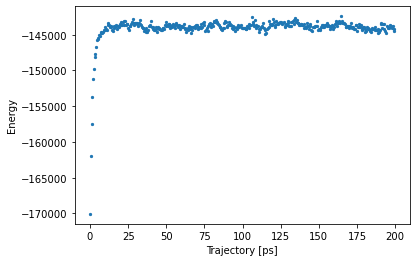

In [10]:
## == Equilibration == ##
equilibrated = False
start_time = time.time()

while equilibrated is False:

    # progress equilibration
    simulation.step(report_steps)

    # get current state of simulation
    curr_state = simulation.context.getState(getEnergy=True)

    # track energy at current time step
    curr_energy = get_energy(curr_state)
    traj_energy.append(curr_energy)

    # get total simulation time
    curr_time = curr_state.getTime()
    curr_time_int = int(curr_time.value_in_unit(unit.picoseconds))

    # time to check if equilibrated?
    if curr_time >= assess_equil_1:

        # only assess equilibriation in last part of traj
        assess_traj = traj_energy[-assess_period:]

        equilibrated = is_equilibrated(assess_traj, window, stride)

        if equilibrated:
            print(f"\nProtein equilibrated after {curr_time}")
            print(f"run time:  {(time.time()-start_time)/60} mins")
            plot_equilibration(traj_energy, report_steps * equil_dt, name="Energy")

        else:
            assess_equil_1 = assess_equil_1 + update_assesment

    # break if does not reach equilibration
    if curr_time > equil_1_max:
        print(
            f"OBS!\n",
            f"First equilibration not reached (╯°□°）╯︵ ┻━┻ \n"
            f"Protein could not equilibrate before {equil_1_max}",
        )
        plot_equilibration(traj_energy, report_steps * equil_dt, name="Energy")

        break
        # sys.exit ()....

# 2nd equilibration -  without positional restraints 

- assess equilibration by potential Energy
- assess equilibration by RMSD 

In [11]:
## extra settings for assessing equilibration ##
# set up for reporting energy without using I/O => faster
traj_energy = []
traj_rmsd = []  # for rmsd

# report energy/rmsd every 2 ps
report_steps = int(2 * unit.picoseconds / equil_dt)

# convert unit to steps
equil_2_steps = int(equil_2_max / equil_dt)
assess_period = int((assess_period_2 / equil_dt) / report_steps)


# how often to check if equilibrated if not equilibrated
update_assesment = 250 * unit.picoseconds

window = 0.8 * unit.nanoseconds
window = int((window / equil_dt) / report_steps)
stride = 50 * unit.picoseconds
stride = int((stride / equil_dt) / report_steps)


 Protein equilibrated  after: 1251.999999984218 ps ヾ(⌐■_■)ノ♪ 
run time took: 391.03971886634827 min


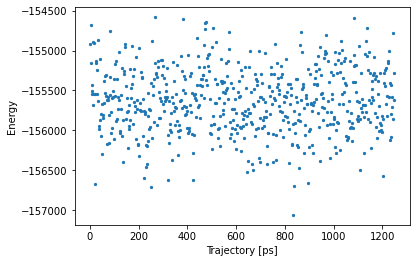

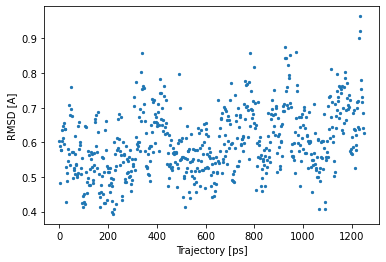

In [12]:
## Remove restraints ##
simulation = remove_pos_restraints(simulation)
assert test_removed_restraints(simulation), "Error - system contains restraints"

# reset start time
simulation.context.setTime(0 * unit.picoseconds)

## Equilibration ##
equilibrated = False
start_time = time.time()

while equilibrated is False:

    # progress equilibration
    simulation.step(report_steps)

    # get current state of simulation
    curr_state = simulation.context.getState(getEnergy=True, getPositions=True)

    # track energy at current time step
    curr_energy = get_energy(curr_state)
    traj_energy.append(curr_energy)

    # track RMSD to input structure
    curr_rmsd = get_rmsd(curr_state, modeller)
    traj_rmsd.append(curr_rmsd)

    # get current simulation time
    curr_time = curr_state.getTime()
    curr_time_int = int(curr_time.value_in_unit(unit.picoseconds))

    # time to check if equilibrated?
    if curr_time >= assess_equil_2:

        # only assess equilibriation in last part of traj
        assess_energy = traj_energy[-assess_period:]
        assess_rmsd = traj_rmsd[-assess_period:]

        E_equilibrated = is_equilibrated(
            assess_energy, window, stride, thrshold=1.0
        )  # thrs=stdev

        rmsd_equilibrated = is_equilibrated(
            assess_rmsd, window, stride, thrshold=1.2
        )  # thrs=stdev

        if E_equilibrated and rmsd_equilibrated:
            print(
                f"\n Protein equilibrated  after: {curr_time} ヾ(⌐■_■)ノ♪",
                f"\nrun time took: {time.time()-start_time} min",
            )
            plot_equilibration(traj_energy, report_steps * equil_dt, name="Energy")
            plot_equilibration(traj_rmsd, report_steps * equil_dt, name="RMSD [A]")
            equilibrated = True

        else:
            print(
                f"{curr_time}: protein not equilibrated yet",
                f"rmsd at: {curr_rmsd}",
                f"run time: {(time.time()-start_time)/60} min",
            )
            equilibrated = False
            assess_equil_2 += update_assesment

    # break if does not equilibrate
    if curr_time > equil_2_max:
        print(
            f"OBS!\n",
            f"First equilibration not reached (╯°□°）╯︵ ┻━┻ \n"
            f"Protein could not equilibrate before {equil_2_max}",
        )
        plot_equilibration(traj_rmsd, report_steps * equil_dt, name="RMSD")

        break
        # sys.exit ()....

assert curr_rmsd < equil_max_rmsd.value_in_unit(unit.angstrom), (
    f"RMSD {curr_rmsd} of equilibrated protein to input protein is too high",
    f" > {equil_max_rmsd}.",
    "Protein is discarded! ",
)

# Log info after equilibration
- Save equilibrated PDB 
- Save RMSD 
- Save plot of RMSD



In [13]:
# save equilibrated PDB
out_file = out_directory + f"equil_{name_pdb}.pdb"
save_pdb(curr_state, modeller, out_file)

# save checkpoint for equil:
save_checkpoint(simulation, system, integrator,  name_pdb + "_equil")

# save rsmd
out_file = out_directory + f"equil_rmsd_{name_pdb}.dat"
with open(out_file, "w") as out:
    out.write("# time_step [ps]\t rmsd [AA]\n")
    for idx, rmsd in enumerate(traj_rmsd):
        timestep = (report_steps * equil_dt * idx).value_in_unit(unit.picoseconds)
        out.write(f"{timestep} \t {rmsd * 10} \n")

Pdb file saved

Checkpoint files saved



# Run Production

In [17]:
# reset start time
simulation.context.setTime(0 * unit.picoseconds)

# change timestep in production run to 4.0 fs
integrator = simulation.context.getIntegrator()
integrator.setStepSize(sim_dt)
assert (
    simulation.context.getIntegrator().getStepSize() == sim_dt
), "Error, timestep not updated"


# setup reporters to save and log simulation and

traj_reporter = setup_reporter_files(simulation, 
                     sim_steps,
                     name_pdb, 
                     out_format,
                     modeller)

# perform simulation
simulation.step(sim_steps)

# close trajectory reporter file
traj_reporter.close()

# save checkpoint files
save_checkpoint(simulation, system, integrator, name_pdb)

# save last frame as pdb
pdb_out = out_directory + f"{name_pdb}_simulation_last_frame.pdb"
curr_state = simulation.context.getState(getPositions=True)
save_pdb(curr_state, modeller, pdb_out)


#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
15.0%	750000	-153792.4529925133	302.86373714807377	0	--
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
15.0%	750000	-153792.4529925133	302.86373714807377	0	--
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
15.0%	750000	-153792.4529925133	302.86373714807377	0	--
16.0%	800000	-154952.31519118103	302.15438951882453	561	43:07
16.0%	800000	-154952.31519118103	302.15438951882453	566	42:42
16.0%	800000	-154952.31519118103	302.15438951882453	572	42:18
17.0%	850000	-155765.09176375926	301.259033620687	569	41:59
17.0%	850000	-155765.09176375926	301.259033620687	572	41:47
17.0%	850000	-155765.09176375926	301.259033620687	575	41:35
18.0%	900000	-155453.1787707198	304.5379342142211	574	41:09
18.0%	900000	-155453.1787707198	304.5379342142211	576	41:01
18.0%	900000	-155453.1787707198	30

NameError: name 'state' is not defined

# Post filtering

In [33]:
curr_state = simulation.context.getState(getPositions=True)
curr_rmsd = get_rmsd(curr_state, modeller)
assert curr_rmsd < rmsd_max.value_in_unit(
    unit.angstrom
), "OBS protein should be discarded -- too high RMSD"

# Visualise 

In [21]:
all_at_once = True # takes a few mins
all_as_traj = False

if visualise is True:
    # load input pdb
    pdb_inp = f"{name_pdb}_clean.pdb"
    topology = md.load(pdb_inp, top=pdb_inp)
    view = nglv.show_mdtraj(topology, gui=True)
    view.clear_representations(component=0)
    view.add_representation(repr_type="rope", color="red", opacity=0.25, component=0)

    # load traj file
    if out_format.lower() == "dcd":
        out_name = f"{name_pdb}_trajectory.dcd"
    elif out_format.lower() == "xtc":
        out_name = f"{name_pdb}_trajectory.xtc"
    md_traj = md.load(out_name, top=topology)
    align_atoms = md_traj.topology.select("name==CA")
    md_traj.superpose(topology, frame=0, atom_indices=align_atoms)

    if all_at_once:
        # load frames every 1 ns => 20 frames
        for frame_idx in range(100):
            if frame_idx % 5 == 0:
                view.add_trajectory(md_traj[frame_idx])

    if all_as_traj:
        view.add_trajectory(md_traj)
view

NGLWidget()

In [26]:
# # visualise box
# if visualise is True:
#     # load input pdb
#     pdb_inp = f"equil_{name_pdb}.pdb"
#     topology = md.load(pdb_inp, top=pdb_inp)
#     view = nglv.show_mdtraj(topology)
#     view.add_representation(repr_type="ball+stick", opacity=0.20, component=0)
# #     water = md_traj.topology.select("name==CA")
# view

NGLWidget()